<a href="https://colab.research.google.com/github/SebasTorres13/SS-time-crystals/blob/main/Floquet_Time_Crystals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Floquet Time Crystals

Consideramos sistemas unidimensionales de espín 1/2 con unitarios de Floquet de la forma:
$$ U = exp(-i t_0H_{MBL}) exp(-it_1 \sum_i σ_i^x) $$


Necesitamos expresar de forma correcta a U

In [ ]:
import numpy as np
from scipy.sparse import kron, eye, csc_matrix
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt

#Vamos a utilizar matrices sparse para hacer más eficiente el programa
# Definimos las matrices de Pauli y la identidad como matrices sparse
sx = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))  # Pauli_X
sz = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex)) # Pauli_Z
id2 = csc_matrix(np.eye(2, dtype=complex))

def prod_kron_n(ops): #Calcula el producto de una lista de operadores.
    result = ops[0]   #ops: operadores (matrices) en cada sitio
    for op in ops[1:]:
        result = kron(result, op)
    return result

def op_local(op, sit, L): #Crea un operador local que actúa sólo en un sitio y como identidad en el resto.
                           #op: operador (sx o sz)
                           #sit: índice del sitio
                           #L: número total de sitios
    ops = [id2] * L
    ops[sit] = op
    return prod_kron_n(ops)

def op_ady(op1, op2, sit, L):   #Crea un operador que actúa sobre los sitios adyacentes (vecinos).
    ops = [id2] * L
    ops[sit] = op1
    ops[sit + 1] = op2
    return prod_kron_n(ops)

def H_MBL(L, J=1.0, hz_max=1.0, hx_max=0.3, seed=None):
    #Construye el Hamiltoniano de MBL.

    if seed is not None:
        np.random.seed(seed)

    H = csc_matrix((2**L, 2**L), dtype=complex)

    # Campo en dirección z
    hz = np.random.uniform(0, hz_max, size=L)
    for i in range(L):
        H += hz[i] * op_local(sz, i, L)

    # Campo en dirección x
    hx = np.random.uniform(0, hx_max, size=L)
    for i in range(L):
        H += hx[i] * op_local(sx, i, L)

    # Interacción entre vecinos
    Ji = np.random.uniform(J/2, 3*J/2, size=L - 1)
    for i in range(L - 1):
        H += Ji[i] * op_ady(sz, sz, i, L)

    return H

def sigma_x_sum(L):

    return sum(op_local(sx, i, L) for i in range(L))

def op_floquet(L, t0, t1, J, hz, hx, seed=None):

    #Construye el operador unitario de Floquet:
    #U = exp(-i t0 H_MBL) · exp(-i t1 ∑ σ^x_i)

    Hmbl = H_MBL(L, J=J, hz_max=hz, hx_max=hx, seed=seed)
    Hx = sigma_x_sum(L)

    U1 = expm(-1j * t0 * Hmbl)  # evolución bajo H_MBL
    U2 = expm(-1j * t1 * Hx)
    return U1 @ U2


In [ ]:
def est_ini(L, theta=np.pi/8): #Construimos el estado inicial:|ψ⟩ = ⊗_i (cos(θ)|0⟩ + sin(θ)|1⟩)

    up = np.array([1, 0], dtype=complex)
    down = np.array([0, 1], dtype=complex)
    psi_sit = np.cos(theta) * up + np.sin(theta) * down

    psi = psi_sit
    for _ in range(L - 1):   #usamos _ para que la acción se repita L-1 veces, ya que comenzamos en el primer sitio
        psi = np.kron(psi, psi_sit)
    return psi


def med_mag_z(psi, L):  #Calcula ⟨σ^z_i⟩ para cada sitio i del estado psi.
    mz = []
    for i in range(L):
        Sz_i = op_local(sz, i, L)
        mz.append(np.real(np.vdot(psi, Sz_i @ psi)))
    return np.array(mz)


#Definimos la descomposición de Schmidt
def schmidt_desc(psi, L):
  dim= 2**(L//2) #Elegimos esta división del sistema en dos partes justo a la mitad
  psi_matrix= psi.reshape(dim, -1)
  u, s, vh = np.linalg.svd(psi_matrix, full_matrices=False)
  return s

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


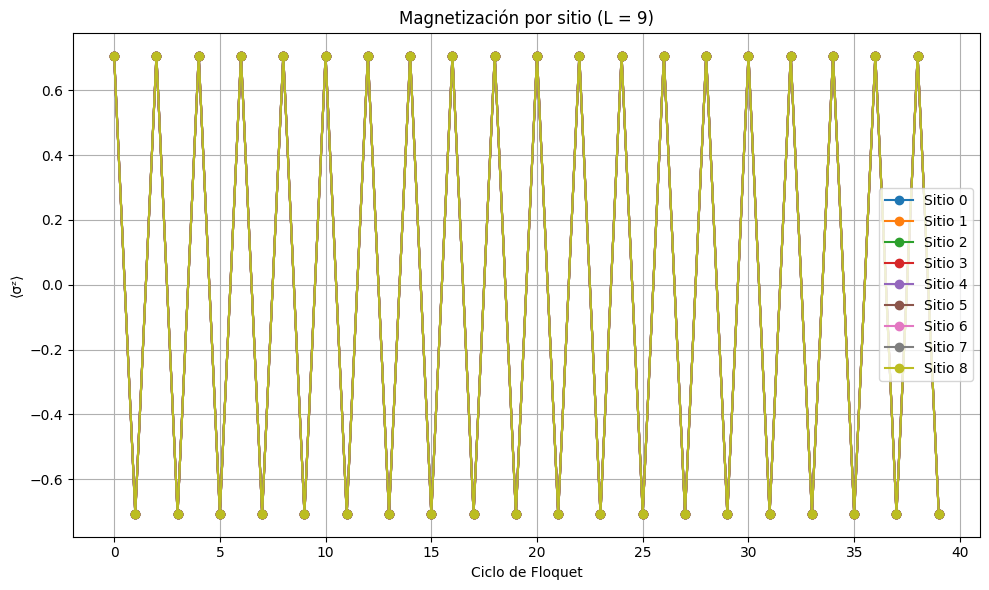

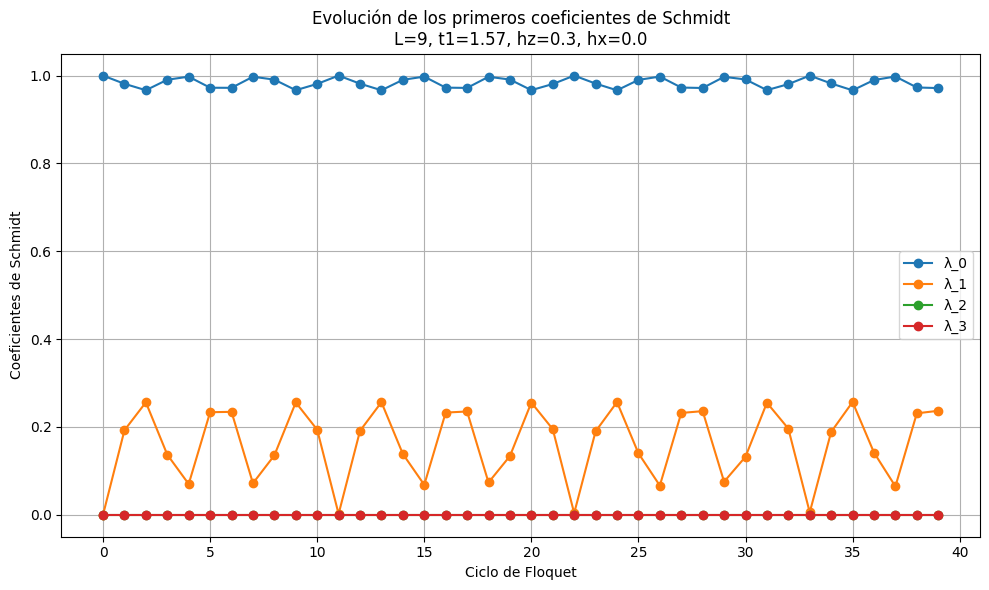

In [ ]:
#Parámetros del sistema
L = 9             # número de sitios (<= 10)
t0 = 1.0          # tiempo bajo H_MBL
t1 = np.pi / 2
J = 1.0           # fuerza de acoplamiento
hz = 0.3          # amplitud en z
hx = 0.0          # amplitud en x
n_pasos = 40      # ciclos de evolución

#Simulación de Floquet
U = op_floquet(L, t0, t1, J, hz, hx, seed=None)
psi = est_ini(L)

magneti = []
schmidt_hist=[]

for paso in range(n_pasos):
    mz = med_mag_z(psi, L)
    magneti.append(mz)

    s_vals=schmidt_desc(psi, L)
    schmidt_hist.append(s_vals)
    psi = U @ psi  # evolución unitaria

magneti = np.array(magneti)

#Gráfico de la evolución temporal
plt.figure(figsize=(10, 6))
for i in range(L):
    plt.plot(magneti[:, i],marker='o', label=f'Sitio {i}')
plt.xlabel('Ciclo de Floquet')
plt.ylabel('⟨σᶻ⟩')
plt.title(f'Magnetización por sitio (L = {L})')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

#Gráfico de los primeros coeficientes de Schmidt
plt.figure(figsize=(10, 6))
for k in range(4):
  vals_k= [s[k] if len(s) > k else 0 for s in schmidt_hist]
  plt.plot(vals_k, marker='o', label=f'λ_{k}')
plt.title(f'Evolución de los primeros coeficientes de Schmidt\nL={L}, t1={t1:.2f}, hz={hz}, hx={hx}')
plt.xlabel('Ciclo de Floquet')
plt.ylabel('Coeficientes de Schmidt')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


λ

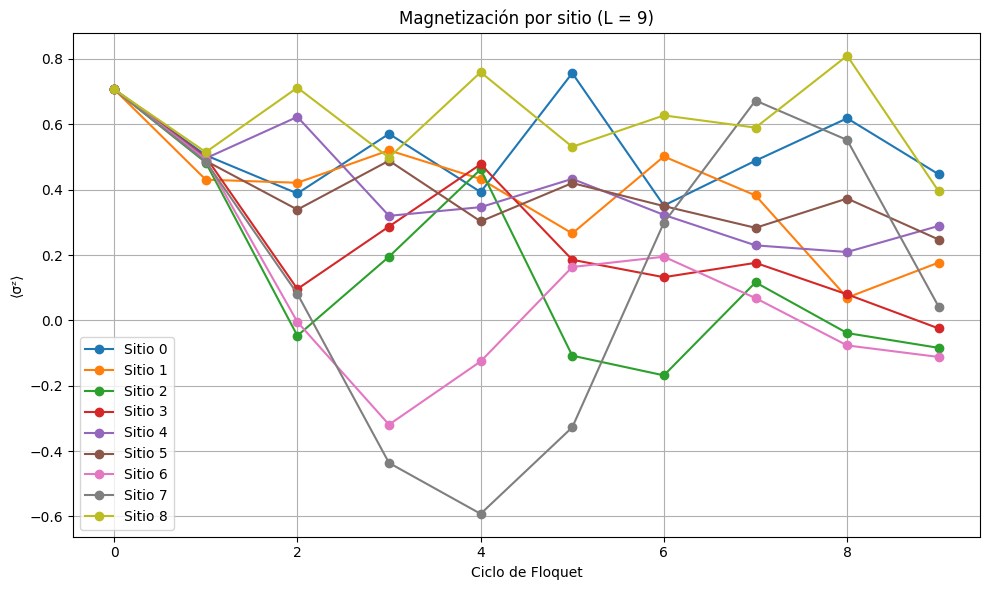

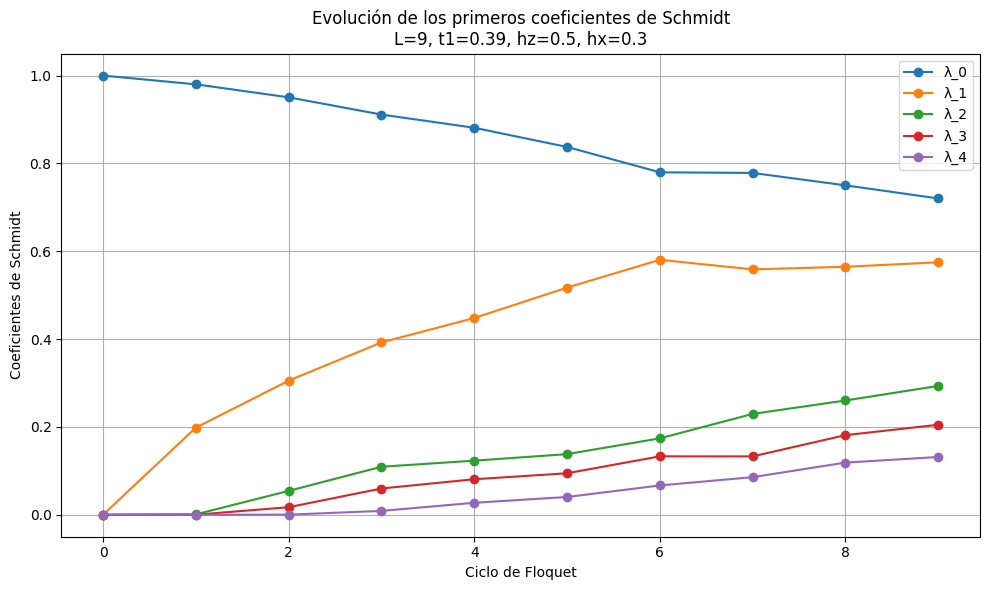

In [ ]:
#Parámetros del sistema (cambiamos t1 para ver el comportamiento y los valores de interacción)
L = 9             # número de sitios (<= 10)
t0 = 1.0          # tiempo bajo H_MBL
t1 = np.pi / 8
J = 1.5           # fuerza de acoplamiento
hz = 0.5          # amplitud en z
hx = 0.3           # amplitud en x
n_pasos = 10      # ciclos de evolución

#Simulación de Floquet
U = op_floquet(L, t0, t1, J, hz, hx, seed=None)
psi = est_ini(L)

magneti = []
schmidt_hist=[]

for paso in range(n_pasos):
    mz = med_mag_z(psi, L)
    magneti.append(mz)

    s_vals=schmidt_desc(psi, L)
    schmidt_hist.append(s_vals)
    psi = U @ psi  # evolución unitaria

magneti = np.array(magneti)

#Gráfico de la evolución temporal
plt.figure(figsize=(10, 6))
for i in range(L):
    plt.plot(magneti[:, i],marker='o', label=f'Sitio {i}')
plt.xlabel('Ciclo de Floquet')
plt.ylabel('⟨σᶻ⟩')
plt.title(f'Magnetización por sitio (L = {L})')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

#Gráfico de los primeros coeficientes de Schmidt
plt.figure(figsize=(10, 6))
for k in range(5):
  vals_k= [s[k] if len(s) > k else 0 for s in schmidt_hist]
  plt.plot(vals_k, marker='o', label=f'λ_{k}')
plt.title(f'Evolución de los primeros coeficientes de Schmidt\nL={L}, t1={t1:.2f}, hz={hz}, hx={hx}')
plt.xlabel('Ciclo de Floquet')
plt.ylabel('Coeficientes de Schmidt')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
